In [58]:
#Best Library for Regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use("fivethirtyeight")

import warnings
warnings.simplefilter('ignore')

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error

# Regression
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

## Evaluation Matrix

In [59]:
def metric(y,y0):
    assert len(y)==len(y0)
    return 100-np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0),2)))

def metric_lgb(y_pred,data):
    y_true = data.get_label()
    result = metric(y_true,y_pred)
    
    return '100-rmse', result,True

## Importing Data

In [60]:
train_1 = pd.read_csv("Train.csv")
test_1 = pd.read_csv("Test.csv")
sub = pd.read_csv("sample_submission.csv")

print("Train Shape : {}\nTest Shape: {}\nSub Shape: {}".format(train_1.shape, test_1.shape, sub.shape))

Train Shape : (33750, 15)
Test Shape: (14454, 14)
Sub Shape: (4, 2)


In [61]:
train = train_1.copy()
test = test_1.copy()

In [62]:
train.head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,2012-10-02 09:00:00,None,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,2012-10-02 10:00:00,None,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,2012-10-02 11:00:00,None,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,2012-10-02 12:00:00,None,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,2012-10-02 13:00:00,None,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918


######  Removing the duplicated values

In [63]:
train[train.duplicated(subset=['date_time'])].head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
179,2012-10-10 07:00:00,None,69,23,3,220,3,3,281.25,0.0,0.0,99,Drizzle,light intensity drizzle,6793
181,2012-10-10 08:00:00,None,82,33,3,150,7,7,280.10,0.0,0.0,99,Drizzle,light intensity drizzle,6283
183,2012-10-10 09:00:00,None,188,36,3,170,6,6,279.61,0.0,0.0,99,Drizzle,light intensity drizzle,5680
270,2012-10-14 09:00:00,None,132,37,5,350,8,8,282.43,0.0,0.0,57,Mist,mist,2685
271,2012-10-14 09:00:00,None,285,26,7,330,7,7,282.43,0.0,0.0,57,Haze,haze,2685


In [64]:
# target = 'traffic_volume'

# #Taking Index of train and test dupliucated rows from dataset 
# duplicate_train_idx = train[train.duplicated(['date_time', 'traffic_volume'], keep='first')].index
# duplicate_test_idx = test[test.duplicated(['date_time'], keep='first')].index

# #Droping All the duplicated values same in date_time and traffic_volume
# train.drop(duplicate_train_idx, axis=0, inplace=True)
# test.drop(duplicate_test_idx, axis=0, inplace=True)

# #Reseting the index
# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)
# test[target] = np.nan

# print("New Train Shape : {}\nNew Test Shape : {}".format(train.shape, test.shape))

In [65]:
# train["Dates"] = pd.to_datetime(train['date_time']).dt.date
# train['Time'] = pd.to_datetime(train['date_time']).dt.time
# del train['date_time']

In [66]:
print("Now we have",train.shape[0]," in the train dataframe and we remove ",33750-train.shape[0]," Duplicated values")

Now we have 33750  in the train dataframe and we remove  0  Duplicated values


## Feature Engineering

In [67]:
train_len = train.shape[0]
data = pd.concat([train,test],ignore_index=True)
print(data.shape)

(48204, 15)


### Date and Time Features

In [68]:
def day_date(df,col,drop=False):
    df[col+"_day_hr"] = df[col].dt.hour
    df[col+'_day_month'] = df[col].dt.day
    df[col+'_day_year'] = df[col].dt.dayofyear
    df[col+'_day_week'] = df[col].dt.dayofweek
    df[col+'_day_month'] = df[col].dt.month 
    df[col+'_day_year'] = df[col].dt.year
    df[col+'_week_year'] = df[col].dt.weekofyear
    df[col+'_is_month_end'] = (df[col].dt.is_month_end).astype(int)
    df[col + '_is_week_end'] = ((df[col + '_day_week']) // 5 == 1).astype(float)
    
    if drop:
        df.drop([col],axis=1,inplace=True)
    
    return df

In [69]:
data['date_time'] = pd.to_datetime(data['date_time'], format="%Y-%m-%d %H:%M:%S")
data = day_date(data,'date_time',False)

#### Encoding the data_time by label encoding

In [70]:
le = LabelEncoder()
data['date_time'] = le.fit_transform(data[['date_time']])
print(len(le.classes_))

40575


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 22 columns):
air_pollution_index       48204 non-null int64
clouds_all                48204 non-null int64
date_time                 48204 non-null int64
dew_point                 48204 non-null int64
humidity                  48204 non-null int64
is_holiday                48204 non-null object
rain_p_h                  48204 non-null float64
snow_p_h                  48204 non-null float64
temperature               48204 non-null float64
traffic_volume            33750 non-null float64
visibility_in_miles       48204 non-null int64
weather_description       48204 non-null object
weather_type              48204 non-null object
wind_direction            48204 non-null int64
wind_speed                48204 non-null int64
date_time_day_hr          48204 non-null int64
date_time_day_month       48204 non-null int64
date_time_day_year        48204 non-null int64
date_time_day_week        48204 no

In [72]:
#Encoding the categorical Values
le_1 = LabelEncoder()
for col in data.select_dtypes('object').columns:
    data[col] = le_1.fit_transform(data[col])

## Preprocessing The Data

In [73]:
train = data[:train_len]
test = data[train_len:]

print(" Train Shape :",train.shape,"\n Test Shape :",test.shape)

 Train Shape : (33750, 22) 
 Test Shape : (14454, 22)


In [74]:

test.reset_index(drop=True, inplace=True)
feat = train.columns.tolist()
feat.remove(target)
print("Feature Length : {}".format(len(feat)))

Feature Length : 21


### Train Validation Split

In [75]:
trainX, validX = train_test_split(train, test_size=0.2, shuffle=False, random_state=13)
print("Train Shape : {}\nValid Shape : {}".format(trainX.shape, validX.shape))

Train Shape : (27000, 22)
Valid Shape : (6750, 22)


## Model
### Baselinear

In [76]:
def baseliner(train, features, target, cv=3, metric=make_scorer(metric, True)):
    print("Baseliner Models(All)")
    eval_dict = {}
    models = [
        KNeighborsRegressor(), GaussianNB(), 
        lgb.LGBMRegressor(), ExtraTreesRegressor(), xgb.XGBRegressor(objective='reg:squarederror'), 
        cat.CatBoostRegressor(verbose=0), GradientBoostingRegressor(), RandomForestRegressor(), 
        LinearRegression(), DecisionTreeRegressor(), ExtraTreeRegressor(), AdaBoostRegressor(), 
        BaggingRegressor(), ElasticNet(), Lasso(), Ridge(), 
        ] #SVR(), 

    print("sklearn Model Name  \t  CV")
    print("--" * 50)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}

        results = cross_val_score(model, train[features], train[target], cv=cv, scoring=metric)
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t %.4f \t" % (
            model_name[:21], eval_dict[model_name]['cv']))

### Cross - Validation Type - WalkForward Split

In [77]:
tscv = TimeSeriesSplit(n_splits=3)

In [78]:
baseliner(train,feat,target,cv=tscv,metric=make_scorer(metric,True))

Baseliner Models(All)
sklearn Model Name  	  CV
----------------------------------------------------------------------------------------------------
KNeighborsRegressor 	 98.7512 	
GaussianNB 	 99.1456 	
LGBMRegressor 	 99.4409 	
ExtraTreesRegressor 	 99.6575 	
XGBRegressor 	 99.5417 	
<catboost.core.CatBoo 	 99.5069 	
GradientBoostingRegre 	 99.5229 	
RandomForestRegressor 	 99.4970 	
LinearRegression 	 99.0933 	
DecisionTreeRegressor 	 99.0846 	
ExtraTreeRegressor 	 99.4558 	
AdaBoostRegressor 	 99.5741 	
BaggingRegressor 	 99.5128 	
ElasticNet 	 99.0961 	
Lasso 	 99.1040 	
Ridge 	 99.0961 	


#### Good Performance models are:
1. LightGBM
2. ExtraTreeRegressor
3. BaggingRegressor
4. RandomForestRegressor
5. CatBoost

### LightGBM

In [79]:
def lgb_model(train, features, target, ts=False, plot=True):
    evals_result = {}
    trainX, validX, trainY, validY = train_test_split(train[features], train[target], shuffle=False, test_size=0.2, random_state=13)
    print("LGB Model")
    lgb_train_set = lgb.Dataset(trainX, label=trainY)
    lgb_valid_set = lgb.Dataset(validX, label=validY)

    MAX_ROUNDS = 1111
    lgb_params = {
        "boosting": 'dart',
        "learning_rate": 0.1,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": "regression",
    }

    lgb_model = lgb.train(
        lgb_params,
        train_set=lgb_train_set,
        valid_sets=[lgb_train_set, lgb_valid_set],
        early_stopping_rounds=250,
        verbose_eval=100,
        evals_result=evals_result,
        feval=metric_lgb # New metric to be optimised
    )
    if plot:
        lgb.plot_importance(lgb_model, figsize=(24, 24))
        lgb.plot_metric(evals_result, metric='100-rmse')

    return lgb_model, lgb_model.best_score

LGB Model
[100]	training's l2: 467414	training's 100-rmse: 99.6649	valid_1's l2: 579617	valid_1's 100-rmse: 99.7447
[200]	training's l2: 267842	training's 100-rmse: 99.6924	valid_1's l2: 379988	valid_1's 100-rmse: 99.7883
[300]	training's l2: 157864	training's 100-rmse: 99.7146	valid_1's l2: 278411	valid_1's 100-rmse: 99.8044
[400]	training's l2: 115973	training's 100-rmse: 99.7265	valid_1's l2: 259627	valid_1's 100-rmse: 99.8082
[500]	training's l2: 103294	training's 100-rmse: nan	valid_1's l2: 245075	valid_1's 100-rmse: 99.8105
[600]	training's l2: 87559.3	training's 100-rmse: nan	valid_1's l2: 240894	valid_1's 100-rmse: 99.8087
[700]	training's l2: 88881.9	training's 100-rmse: nan	valid_1's l2: 247077	valid_1's 100-rmse: 99.809
[800]	training's l2: 79927.7	training's 100-rmse: nan	valid_1's l2: 248899	valid_1's 100-rmse: 99.8085
[900]	training's l2: 70505.9	training's 100-rmse: nan	valid_1's l2: 249971	valid_1's 100-rmse: 99.8081
[1000]	training's l2: 66825.8	training's 100-rmse: na

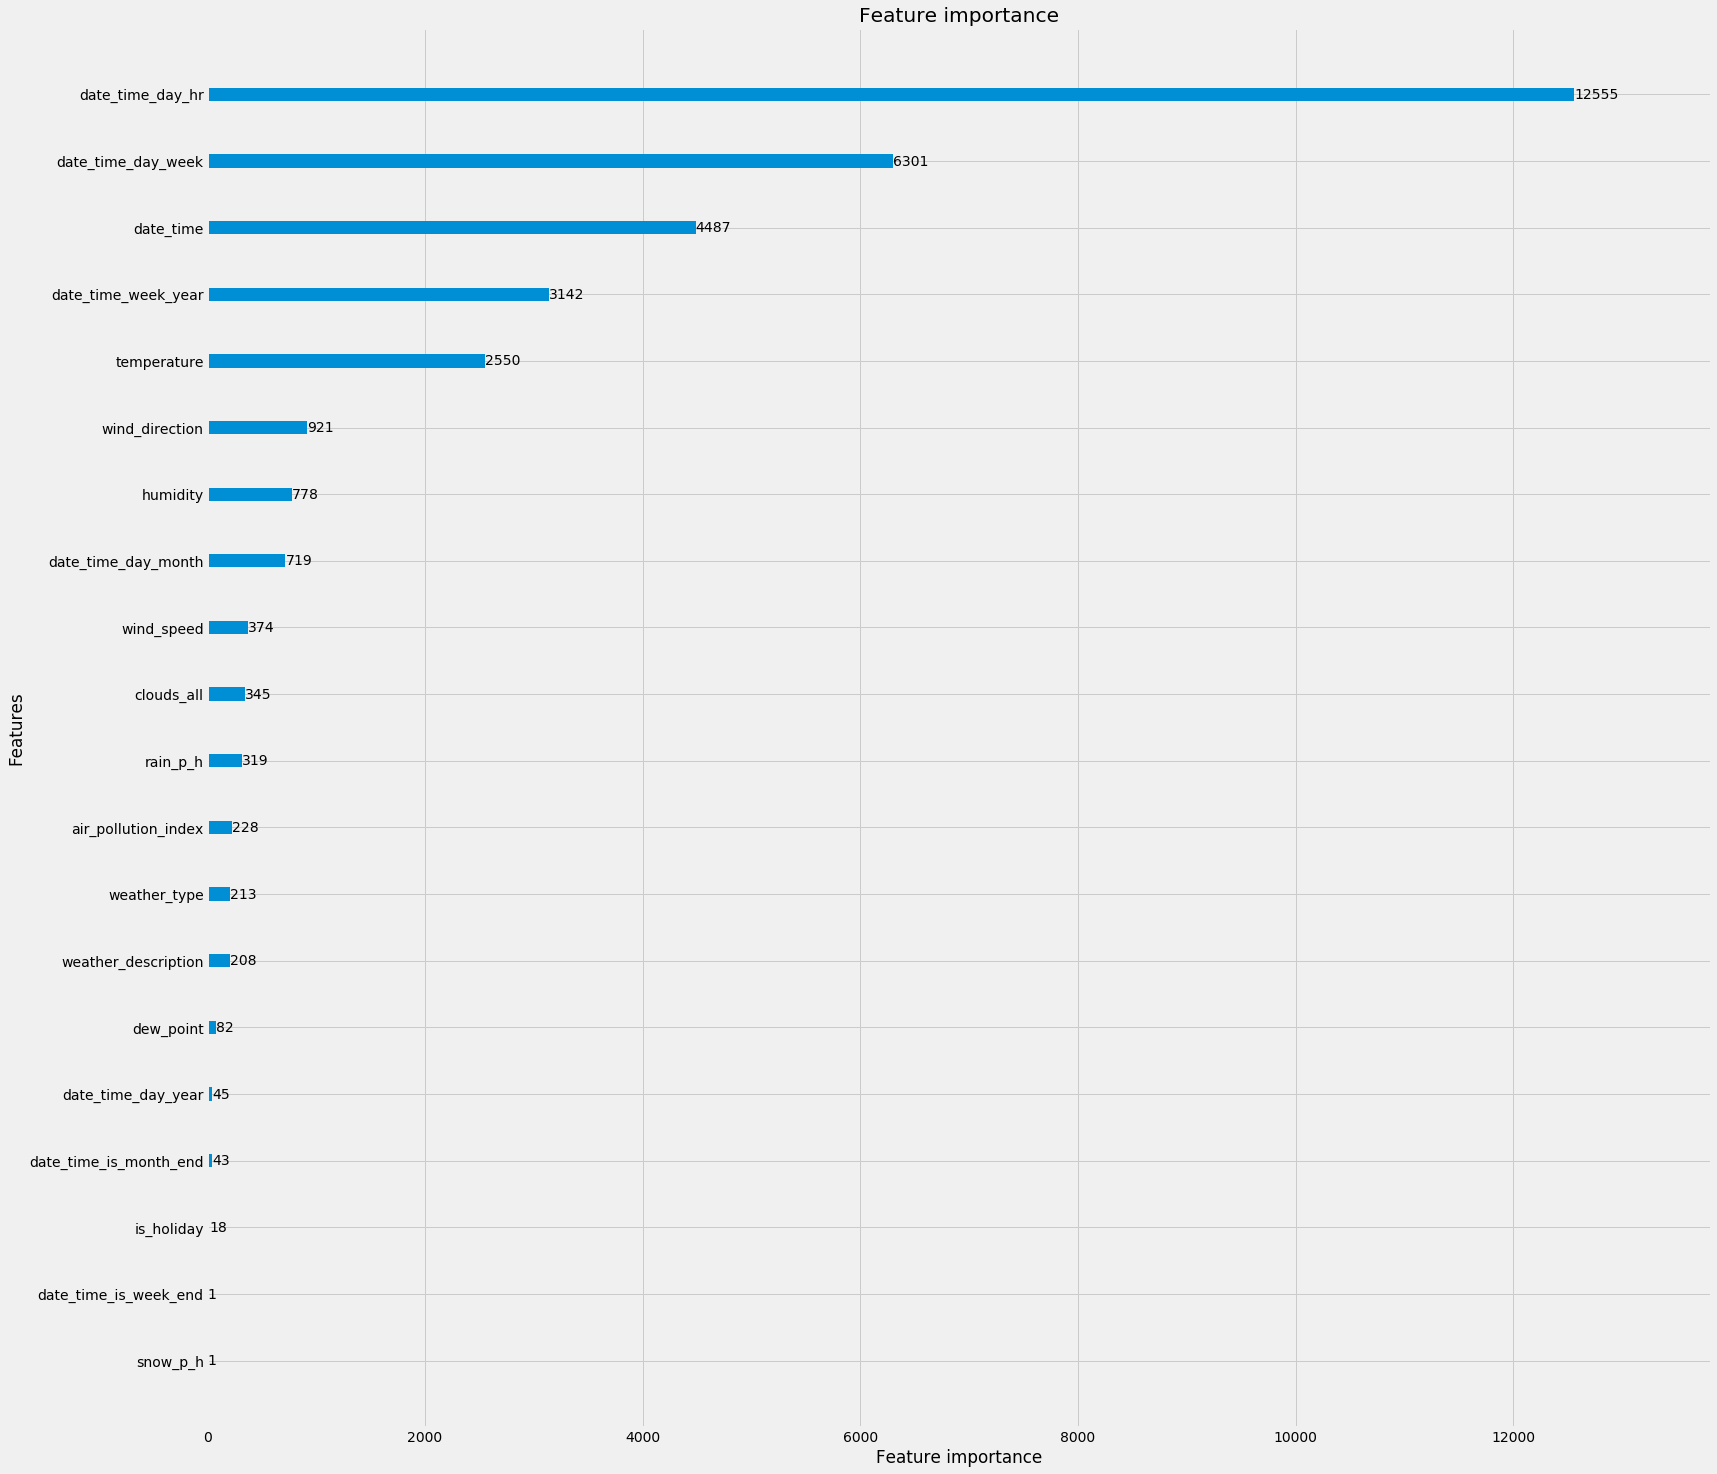

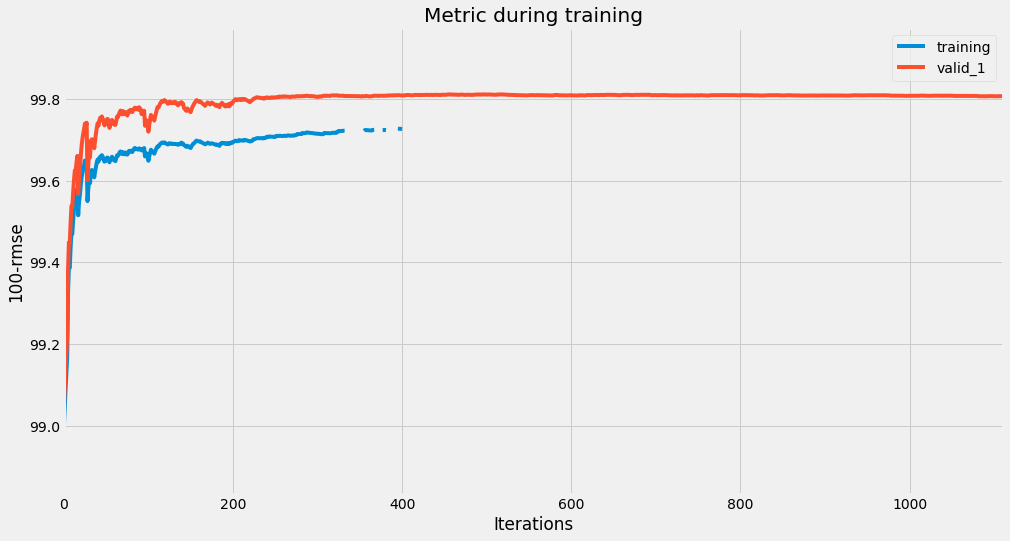

In [80]:
lgbM, score = lgb_model(train,feat,target,True,True)

## Visulalising the prediction

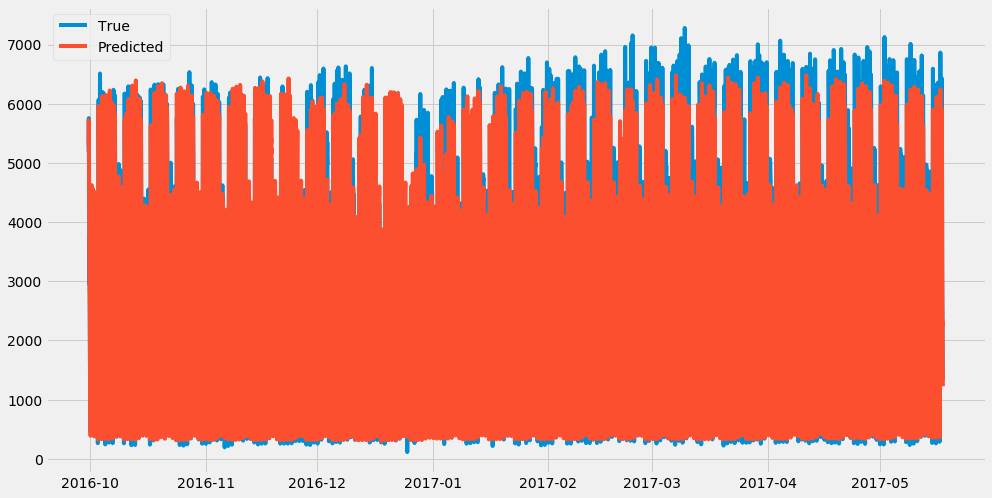

In [81]:
y_preds = lgbM.predict(validX[feat])

plt.figure()
plt.plot(le.inverse_transform(validX['date_time']), validX[target], label='True')
plt.plot(le.inverse_transform(validX['date_time']), y_preds, label='Predicted')

plt.legend(loc='best')
plt.show()

### In Detail

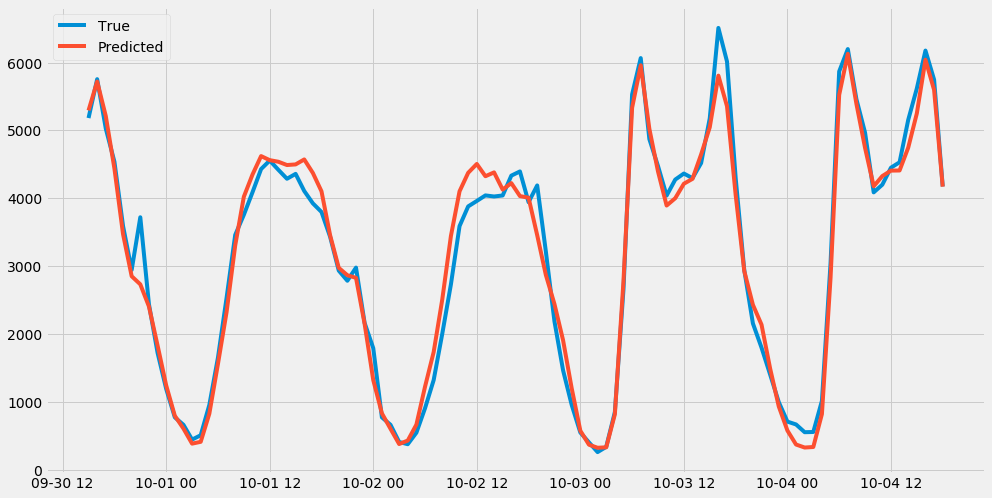

In [82]:
plt.figure()
plt.plot(le.inverse_transform(validX['date_time'].iloc[: 100]), validX[target].iloc[: 100], label='True')
plt.plot(le.inverse_transform(validX['date_time'].iloc[: 100]), y_preds[:100], label='Predicted')

plt.legend(loc='best')
plt.show()

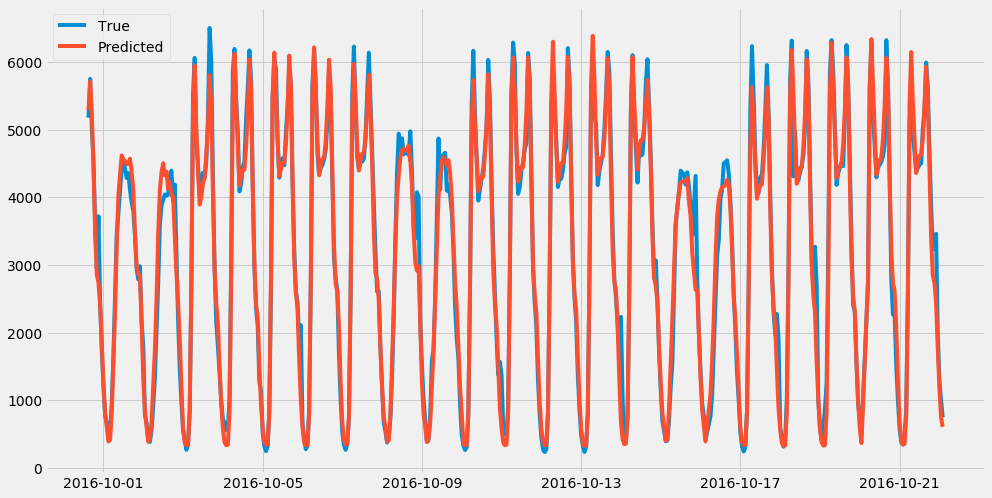

In [83]:
plt.figure()
plt.plot(le.inverse_transform(validX['date_time'].iloc[: 500]), validX[target].iloc[: 500], label='True')
plt.plot(le.inverse_transform(validX['date_time'].iloc[: 500]), y_preds[:500], label='Predicted')

plt.legend(loc='best')
plt.show()

### Training on Full Data

In [84]:
lgbtrain = lgb.Dataset(train[feat],label = train[target])

In [85]:
MAX_ROUNDS = 1111
lgb_params = {
    "boosting": 'dart',
    "learning_rate": 0.1,
    "nthread": -1,
    "seed": 13,
    "num_boost_round": MAX_ROUNDS,
    "objective": "regression",
    'min_split_gain': 0,
}

In [86]:
lgb_model = lgb.train(
    lgb_params,
    train_set=lgbtrain,
    verbose_eval=100,
    feval=metric_lgb, # New metric to be optimised
)

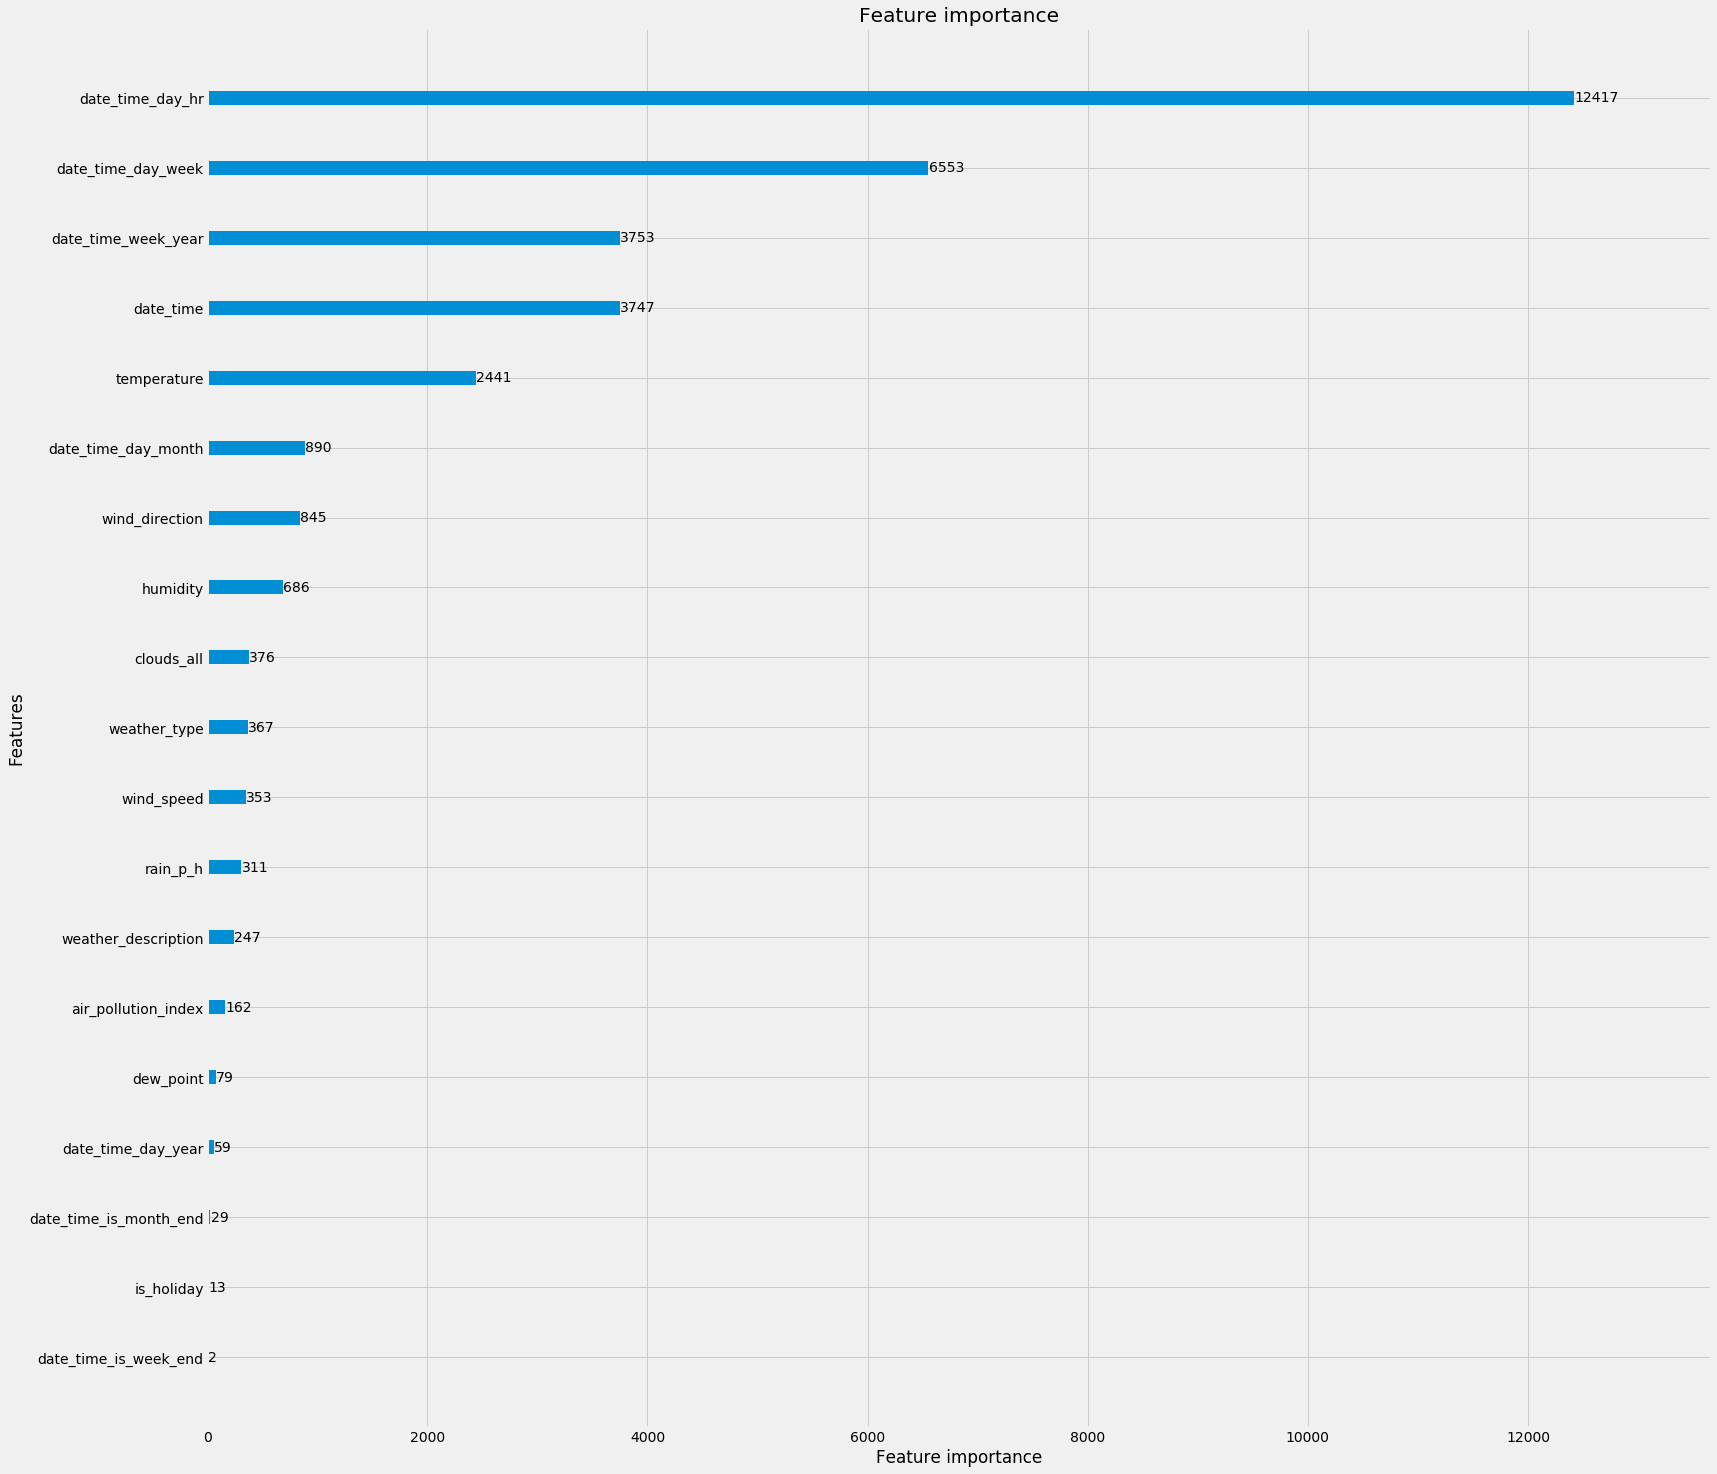

In [87]:
lgb.plot_importance(lgb_model, figsize=(24, 24))

In [88]:
y_preds = lgb_model.predict(test[feat])
test[target] = y_preds
test[target].head()

0    811.430377
1    811.430377
2    811.430377
3    397.041696
4    397.041696
Name: traffic_volume, dtype: float64

In [89]:
test.head()

,air_pollution_index,clouds_all,date_time,dew_point,humidity,is_holiday,rain_p_h,snow_p_h,temperature,traffic_volume,visibility_in_miles,weather_description,weather_type,wind_direction,wind_speed,date_time_day_hr,date_time_day_month,date_time_day_year,date_time_day_week,date_time_week_year,date_time_is_month_end,date_time_is_week_end
0,73,90,28589,4,63,7,0.0,0.0,285.15,811.430377,4,18,6,27,1,0,5,2017,3,20,0,0.0
1,251,90,28589,4,63,7,0.0,0.0,285.15,811.430377,4,17,5,27,1,0,5,2017,3,20,0,0.0
2,75,90,28589,1,56,7,0.0,0.0,285.15,811.430377,1,11,2,0,1,0,5,2017,3,20,0,0.0
3,98,90,28590,2,56,7,0.0,0.0,284.79,397.041696,2,9,6,351,1,1,5,2017,3,20,0,0.0
4,283,90,28590,1,56,7,0.0,0.0,284.79,397.041696,1,17,5,351,1,1,5,2017,3,20,0,0.0


In [92]:
sub = test_1['date_time']
sub = pd.DataFrame(sub)

In [94]:
sub[target] = y_preds

In [99]:
sub.head()

,date_time,traffic_volume
0,2017-05-18 00:00:00,811.430377
1,2017-05-18 00:00:00,811.430377
2,2017-05-18 00:00:00,811.430377
3,2017-05-18 01:00:00,397.041696
4,2017-05-18 01:00:00,397.041696


In [96]:
sub.to_csv("lgb_final.csv",index=False)